# MIPS   

TODO:

Nondimensionalize 


# Dependency

In [ ]:
import cupy as cp
!pip show cupy-cuda111

Name: cupy-cuda111
Version: 9.4.0
Summary: CuPy: NumPy & SciPy for GPU
Home-page: https://cupy.dev/
Author: Seiya Tokui
Author-email: tokui@preferred.jp
License: MIT License
Location: /usr/local/lib/python3.7/dist-packages
Requires: fastrlock, numpy
Required-by: 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from time import time

from numba import jit, njit, prange
from numba.typed import List
from matplotlib.animation import FuncAnimation, PillowWriter

# Utils


In [3]:
@njit()
def set_seed(a):
    np.random.seed(a)

def display(posx, posy):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Now, we draw our points with a gradient of colors.
    ax.scatter(np.remainder(posx[:len(posx)//2],1), np.remainder(posy[:len(posx)//2],1), linewidths=0.5,
               marker='o', s=5, facecolors='none', edgecolors='teal', cmap=plt.cm.jet)
    ax.scatter(np.remainder(posx[len(posx)//2:],1), np.remainder(posy[len(posx)//2:],1), linewidths=0.5,
            marker='o', s=5, facecolors='none', edgecolors='coral', cmap=plt.cm.jet)

    ax.axis('equal')
    ax.grid()
    # ax.set_axis_off()


def save(file_name, data):
    """ Saves the model to a numpy file.
    """
    print("Writing to " + file_name)
    np.savez_compressed(file_name, **data)


def load(file_name):
    """ Loads the model from numpy file.
    """
    print("Loading from " + file_name)
    return dict(np.load(file_name))

# def write_history(*data):
    

def record_gif(data):
    fig,ax = plt.subplots()
    def animate(i):
        fig.clear()
        line = display(data[i][0],data[i][1])
        ax.set_title("iteration " + str(i))
        return line

    ani = FuncAnimation(fig, animate, interval=200, frames=354)

    ani.save("test0.gif", dpi=200, writer=PillowWriter(fps=24))

def generate_points_with_min_distance(n, shape, min_dist):
  """
      n: number of points
      example:
      generate_points_with_min_distance(n=100, shape=(100,100), min_dist=0.1)
  """
  # compute grid shape based on number of points
  width_ratio = shape[1] / shape[0]
  num_y = np.int32(np.sqrt(n / width_ratio))
  num_x = np.int32(n / num_y)

  # create regularly spaced neurons
  x = np.linspace(0., shape[1], num_x, dtype=np.float32)
  y = np.linspace(0., shape[0], num_y, dtype=np.float32)
  coords = np.stack(np.meshgrid(x, y), -1).reshape(-1,2)

  # compute spacing
  init_dist = np.min((x[1]-x[0], y[1]-y[0]))

  # perturb points
  max_movement = (init_dist - min_dist)/2
  noise = np.random.uniform(low=-max_movement,
                              high=max_movement,
                              size=(len(coords), 2))
  coords += noise

  return coords

(10000, 2)


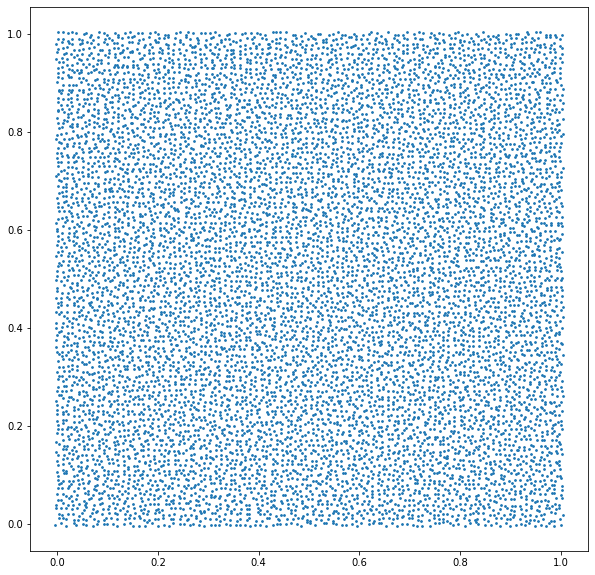

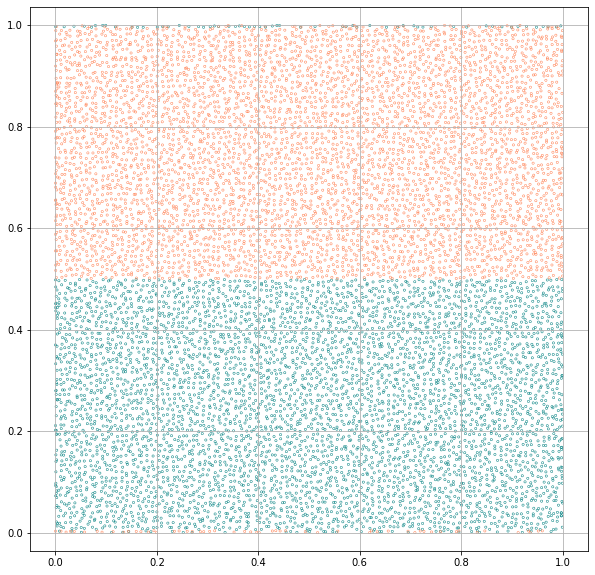

In [ ]:
# Test Display
coords = generate_points_with_min_distance(n=10000, shape=(1,1), min_dist=0.002)
print(coords.shape)
plt.figure(figsize=(10,10))
plt.scatter(coords[:,0], coords[:,1], s=3)
display(coords[:,0], coords[:,1])

# Code Body

In [4]:
@njit()
def pos_updater(posx, posy, vecx, vecy, theta,
                N, step, v_p, D_r, D_t, gamma):

    # Interaction and Self-drive Motion
    posx += step * (vecx + v_p * np.cos(theta)) / gamma
    posy += step * (vecy + v_p * np.sin(theta)) / gamma

    # Diffusion
    t1 = np.sqrt(2*D_t*step)
    t2 = np.sqrt(2*D_r*step)
    posx += (t1*np.random.randn(N)).astype(np.float32)
    posy += (t1*np.random.randn(N)).astype(np.float32)
    theta += (t2*np.random.randn(N)).astype(np.float32)



@njit()
def LJPotential(x, y, d2, r2, epsilon):
    '''
        calculat the FJ potential
    :param x: difference on x
    :param y: difference on y
    :param d2: squared distance x^2 + y^2
    :param r2: squared of radius of particles r , r^6
    :param epsilon: the potential strength
    :return:
    '''
    rx = x/d2
    ry = y/d2
    k = (r2/d2)**3
    s = epsilon * (k - 2 * k**2)
    return s*rx, s*ry


@njit(parallel=True)
def vec_updater(grid, posx, posy, vecx, vecy, theta,
                N, M, r, r2, rm, epsilon):

    r_lower = -1 * rm
    r_upper = rm

    for idx_grid in prange(len(grid)):
      points = grid[idx_grid]
      # Run with numba parallel iteration
      for idx_i in prange(len(points)):
          i = points[idx_i]
          #======================================================
          # Collide Detection
          # TODO optimization on the 
          index_range = get_cal_range(grid, idx_grid % M, idx_grid // M)  # check all particles

          for idx_j in prange(len(index_range)):
              j = index_range[idx_j]
              # check if two particles are contacted, most particle are not contacted
              x1 = posx[i]
              x2 = posx[j]
              x_diff = x1 - x2

              if r_lower < x_diff < r_upper:

                  y1 = posy[i]
                  y2 = posy[j]
                  y_diff = y1 - y2

                  if r_lower < y_diff < r_upper:

                      d2 = x_diff ** 2 + y_diff ** 2 + 1e-16
                      if d2 < rm:
                          # if contact add the repulsive force
                          vpx, vpy = LJPotential(x_diff, y_diff, d2, r2, epsilon)
                          vecx[i] += vpx
                          vecy[i] += vpy
                          vecx[j] -= vpx
                          vecy[j] -= vpy

@jit(parallel=True)
def interval_seperation(pos, M):
  idx = pos * M  // 1
  grid = List()
  for i in range(M):
    grid.append(np.zeros(1).astype(np.int64))
  # return grid
  for i in prange(M):
    grid[i] = np.where(idx==i)[0]
  return grid

@njit(parallel=True)
def grid_seperation_slow(posx, posy, M):
  M = int(M)
  idx = posx * M // 1
  idy = posy * M // 1
  grid = List()
  for i in range(M*M):
    grid.append(List(np.where((idx==i%M) & (idy==i//M))[0]))
  return grid


@njit(parallel=True)
def grid_seperation1(grid, posx, posy, M):
  M = int(M)
  idx = posx * M // 1
  idy = posy * M // 1
  for i in prange(M*M):
    grid[i] = List(np.where((idx==i%M) & (idy==i//M))[0])
  return grid


@njit(parallel=True)
def grid_seperation(grid, posx, posy, M):
  M = int(M)
  N = len(posx)
  idx = posx * M // 1
  idy = posy * M // 1
  lst = [[0] for _ in range(M**2)]
  for i in range(N):
    temp = idy[i]
    if temp == M: temp=0
    t = np.int64(idx[i] + temp*M)
    lst[t].append(np.int64(i))
  for i in range(M**2):
    grid[i] = List(lst[i])
  return grid


def grid_init(M):
  grid = List()
  for i in range(M*M):
    grid.append(List(np.zeros(1).astype(np.int64)))
  return grid

@njit()
def get_cal_range(grid, indx, indy):
  '''
    For G(ind1, ind2)
    Get the range in the following grid denoted by O. and skip X
      ^
    O O O
    X G O ->
    X X X
  '''
  M = int(math.sqrt(len(grid)))
  if indx == M-1: indx=-1
  if indy == M-1: indy=-1
  row = indx*M
  col = indy
  c = list(grid[row+col][1:])
  r = list(grid[row+col+1][1:])
  t = list(grid[row+col+M][1:])
  tr = list(grid[row+col+M+1][1:])

  if indy == 0: col = M
  tl = list(grid[row+col+M-1][1:])
  return c+r+t+tl+tr
  # return r


@njit()
def run(grid, posx, posy, vecx, vecy, theta,
        N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma):
    vec_updater(grid, posx, posy, vecx, vecy, theta, N, M, r, r2, rm, epsilon)
    pos_updater(posx, posy, vecx, vecy, theta, N, step, v_p, D_r, D_t, gamma)
    
    posx = np.remainder(posx, 1).astype(np.float32)
    posy = np.remainder(posy, 1).astype(np.float32)
    theta = np.remainder(theta, 2 * np.pi).astype(np.float32)
    grid = grid_seperation(grid, posx, posy, M)

    return grid, posx, posy, vecx, vecy, theta


(0.0, 1.0)

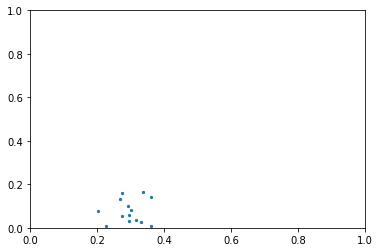

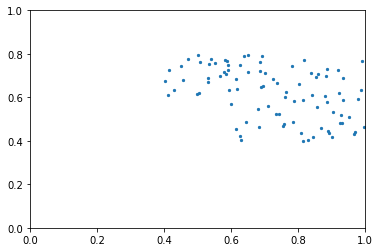

In [13]:
tempx = np.arange(0,1,0.002)
tempy = np.arange(0,1,0.002)
np.random.shuffle(tempy)
np.random.shuffle(tempx)

# intervals = interval_seperation(tempx,5)
# print(repr(intervals))
# print(repr(intervals[0]))
grid = grid_init(5)
grid = grid_seperation1(grid, tempx,tempy,5)
mask=grid[1]
plt.scatter(tempx[mask],tempy[mask],s=5)
plt.xlim(0,1)
plt.ylim(0,1)
# print(repr(grid))
mask = get_cal_range(2,3, grid)
# print(repr(mask))
plt.figure()
plt.scatter(tempx[mask],tempy[mask],s=5)
plt.xlim(0,1)
plt.ylim(0,1)


# Hyperparameters

Fine tuned hyperparameters.

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
r = 1e-3

scales = AttrDict()

attr_args = AttrDict()
hyperparameters = {
    'seed': 0,
    'N' : 10,  # number of particles
    'M' : 10,
    'step' : 1e-4,
    'epoch' : 3000,
    'r' : r,
    'r2' : r ** 2,
    'rm' : 2**(1/6) * r,
    'gamma' : 1,  # fraction
    'epsilon' : 1e-15,  # potential depth times 4
    'v_p' : 1,  # mean speed
    'D_t' : 0,  # transition diffusion
    'D_r' : 0,  # rotation diffusion
    'is_save' : False,
    'is_load' : False,
    }
attr_args.update(hyperparameters)

# Tests

Collision transportation, need at least one step.

Speed update when two particle contact.

iid Gaussian

## Test0 - Movement test

iteration:  0 time:  2.2685294151306152
iteration:  1 time:  2.2366085052490234
iteration:  2 time:  0.0
iteration:  3 time:  0.0
iteration:  4 time:  0.0
iteration:  5 time:  0.0
iteration:  6 time:  0.0
iteration:  7 time:  0.0
iteration:  8 time:  0.0010449886322021484
iteration:  9 time:  0.0006694793701171875
iteration:  10 time:  0.0
iteration:  11 time:  0.0010023117065429688
iteration:  12 time:  0.0009975433349609375
iteration:  13 time:  0.0
iteration:  14 time:  0.0
iteration:  15 time:  0.0
iteration:  16 time:  0.0
iteration:  17 time:  0.0
iteration:  18 time:  0.0009992122650146484
iteration:  19 time:  0.0
iteration:  20 time:  0.0010025501251220703
iteration:  21 time:  0.0
iteration:  22 time:  0.0009982585906982422
iteration:  23 time:  0.0
iteration:  24 time:  0.0
iteration:  25 time:  0.0
iteration:  26 time:  0.0
iteration:  27 time:  0.0
iteration:  28 time:  0.0
iteration:  29 time:  0.0
iteration:  30 time:  0.0
iteration:  31 time:  0.0
iteration:  32 time:  

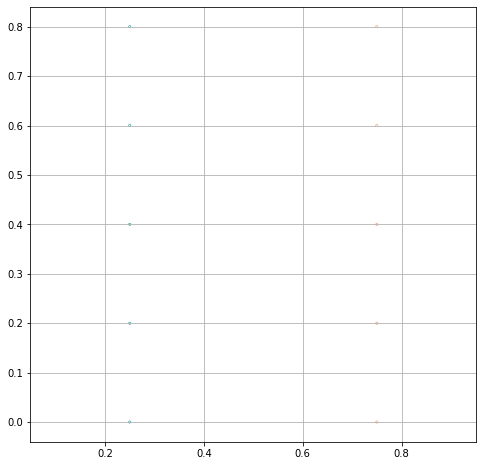

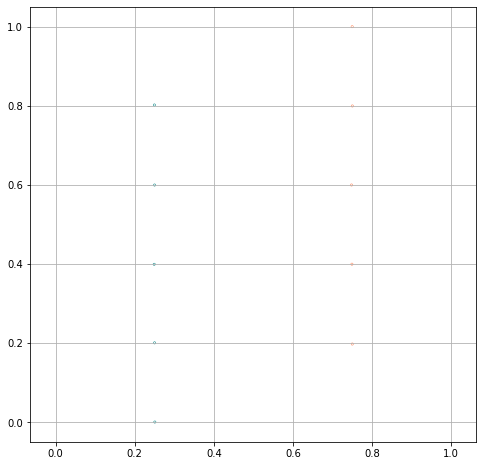

In [8]:
def test0():
    def init(N):
        posx = np.concatenate((np.ones(N//2)*0.25,np.ones(N//2)*0.75))
        posy = np.concatenate((np.linspace(0.2,1,N//2),np.linspace(0.2,1,N//2)))
        theta = np.concatenate((np.ones(N//2)*0,np.ones(N//2)*np.pi))
        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 10  # number of particles
    M = 2
    step = 1e-6
    epoch = 3000
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-3  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)
    display(posx, posy)
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        t2 = time()
        print("iteration: ", _, "time: ", t2-t1)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)

test0()

## Test1 - Collision test

Test if the diffusion is too strong, initialize all the particles in a line

iteration:  0 time:  0.0009932518005371094
iteration:  1 time:  0.003996133804321289
iteration:  2 time:  0.002999544143676758
iteration:  3 time:  0.004003047943115234
iteration:  4 time:  0.003979206085205078
iteration:  5 time:  0.00400090217590332
iteration:  6 time:  0.004000186920166016
iteration:  7 time:  0.004057168960571289
iteration:  8 time:  0.003942966461181641
iteration:  9 time:  0.0029990673065185547
iteration:  10 time:  0.003999471664428711
iteration:  11 time:  0.004088878631591797
iteration:  12 time:  0.00399470329284668
iteration:  13 time:  0.004001140594482422
iteration:  14 time:  0.003998279571533203
iteration:  15 time:  0.003920316696166992
iteration:  16 time:  0.004996776580810547
iteration:  17 time:  0.0029981136322021484
iteration:  18 time:  0.0029997825622558594
iteration:  19 time:  0.003608226776123047
iteration:  20 time:  0.00500035285949707
iteration:  21 time:  0.003998279571533203
iteration:  22 time:  0.0030002593994140625
iteration:  23 time

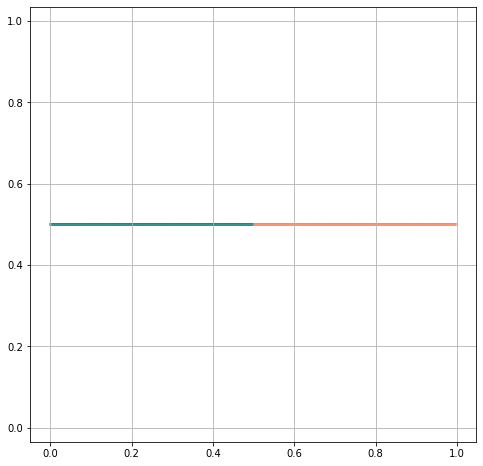

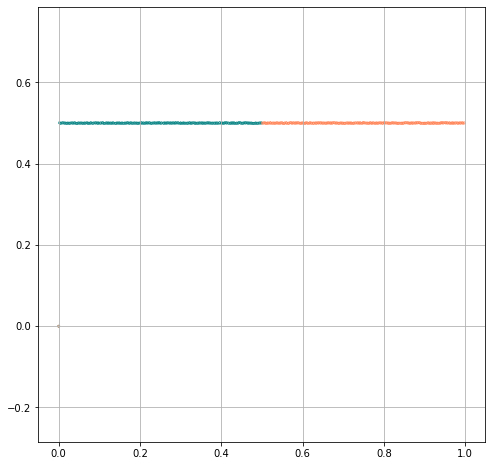

In [9]:
def test1():
    def init(N):
        posx = np.linspace(0, 1, N)
        posy = np.ones(N)/2
        theta = np.random.randn(N)

        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 500  # number of particles
    M = 10
    step = 1e-6
    epoch = 1000
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-3  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)
    display(posx, posy)
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        t2 = time()
        print("iteration: ", _, "time: ", t2-t1)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)

test1()

## Test2

iteration:  0 time:  0.0009634494781494141
iteration:  1 time:  0.004998683929443359
iteration:  2 time:  0.006002902984619141
iteration:  3 time:  0.004995822906494141
iteration:  4 time:  0.005000591278076172
iteration:  5 time:  0.004999637603759766
iteration:  6 time:  0.004998922348022461
iteration:  7 time:  0.004998922348022461
iteration:  8 time:  0.005001068115234375
iteration:  9 time:  0.005000114440917969
iteration:  10 time:  0.005000114440917969
iteration:  11 time:  0.0059986114501953125
iteration:  12 time:  0.0050008296966552734
iteration:  13 time:  0.00599980354309082
iteration:  14 time:  0.004999876022338867
iteration:  15 time:  0.00600123405456543
iteration:  16 time:  0.004998445510864258
iteration:  17 time:  0.005000114440917969
iteration:  18 time:  0.005998849868774414
iteration:  19 time:  0.0050008296966552734
iteration:  20 time:  0.005002021789550781
iteration:  21 time:  0.006998538970947266
iteration:  22 time:  0.004999876022338867
iteration:  23 time

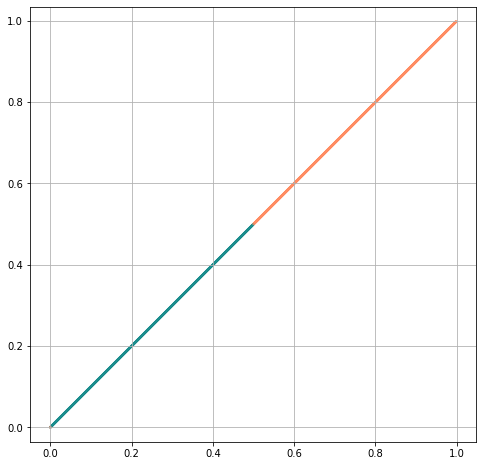

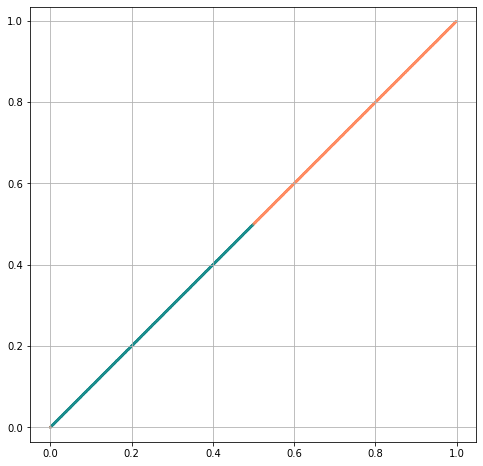

In [18]:
def test2():
    @njit()
    def init(N):
        posx = np.linspace(0, 1, N)
        posy = np.linspace(0, 1, N)
        theta = np.random.randn(N)

        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 800  # number of particles
    M = 10
    step = 1e-7
    epoch = 1000
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-3  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)
    display(posx, posy)
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        t2 = time()
        print("iteration: ", _, "time: ", t2-t1)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)
test2()

## Test3

Test the effect of diffusion in Uniform Distribution

In [4]:
def test3():
    def init(N):
        coords = generate_points_with_min_distance(n=N, shape=(1,1), min_dist=2*r)
        posx = np.array(coords[:,0])
        posy = np.array(coords[:,1])
        theta = np.random.randn(N)
        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    N = 40000  # number of particles
    step = 3e-2
    epoch = 1
    r = 1e-3
    r2 = r ** 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 0  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3*D_t/r2  # rotation diffusion
    is_save = False
    is_load = False

    posx, posy, vecx, vecy, theta = init(N)
    display(posx, posy)
    for _ in range(epoch):
        # print("iteration: ", _)
        run(posx, posy, vecx, vecy, theta,
            N, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        
    if is_save:
        data = {'px': posx,
                'py': posy,
                'vx': vecx,
                'vy': vecy,
                'theta': theta
                }
        save("state.npz", data)
    display(posx, posy)

test3()

# Main Run

In [25]:
def main():
    def init(N):
        coords = generate_points_with_min_distance(n=N, shape=(1,1), min_dist=2*r)
        posx = np.array(coords[:,0])
        posy = np.array(coords[:,1])
        theta = np.random.randn(N)

        vecx = np.zeros(N)
        vecy = np.zeros(N)
        return posx, posy, vecx, vecy, theta

    # Hyper-parameters
    N = 30000  # number of particles
    M = 80
    step = 1e-6
    epoch = int(1e2)
    r = 1e-3  # radius of particle
    r2 = r ** 2  # radius of particle power 2
    rm = 2**(1/6) * r
    gamma = 1  # fraction
    epsilon = 1e-15  # potential depth times 4
    v_p = 1e-4  # mean speed
    D_t = 1e-4  # transition diffusion
    D_r = 3 * D_t/r2  # rotation diffusion
    is_save = True
    is_load = False

    # Initialization
    posx, posy, vecx, vecy, theta = init(N)
    grid = grid_init(M)
    display(posx, posy)
    plt.show()
    
    # Run
    for _ in range(epoch):
        t1 = time()
        grid, posx, posy, vecx, vecy, theta = run(grid, posx, posy, vecx, vecy, theta,
            N, M, r, r2, rm, epsilon, step, v_p, D_r, D_t, gamma)
        t2 = time()
        print("iteration: ", _, "time: ", t2-t1) 
        
        if is_save and (_ % 200==0):
            data = {'px': posx,
                    'py': posy,
                    'vx': vecx,
                    'vy': vecy,
                    'theta': theta
                    }
            save("state"+str(_)+".npz", data)
    return posx, posy


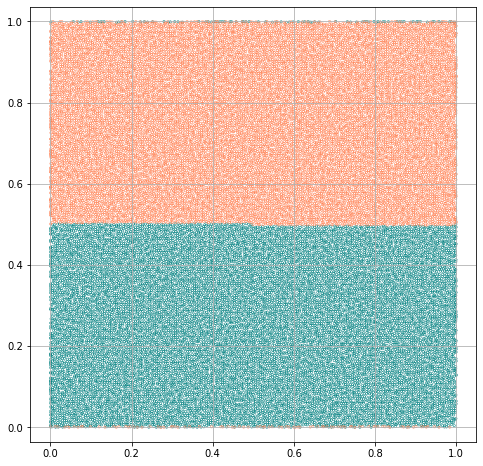

iteration:  0 time:  4.2389607429504395
Writing to state0.npz
iteration:  1 time:  2.2131941318511963
iteration:  2 time:  0.12168645858764648
iteration:  3 time:  0.11554098129272461
iteration:  4 time:  0.14495015144348145
iteration:  5 time:  0.11990475654602051
iteration:  6 time:  0.11877822875976562
iteration:  7 time:  0.11818146705627441
iteration:  8 time:  0.11860036849975586
iteration:  9 time:  0.11361432075500488
iteration:  10 time:  0.1157064437866211
iteration:  11 time:  0.11559009552001953
iteration:  12 time:  0.11767435073852539
iteration:  13 time:  0.11692023277282715
iteration:  14 time:  0.13096022605895996
iteration:  15 time:  0.1421351432800293
iteration:  16 time:  0.12700200080871582
iteration:  17 time:  0.13292622566223145
iteration:  18 time:  0.12595295906066895
iteration:  19 time:  0.1273791790008545
iteration:  20 time:  0.12613534927368164
iteration:  21 time:  0.12650632858276367
iteration:  22 time:  0.12000155448913574
iteration:  23 time:  0.115

In [26]:
result = main()

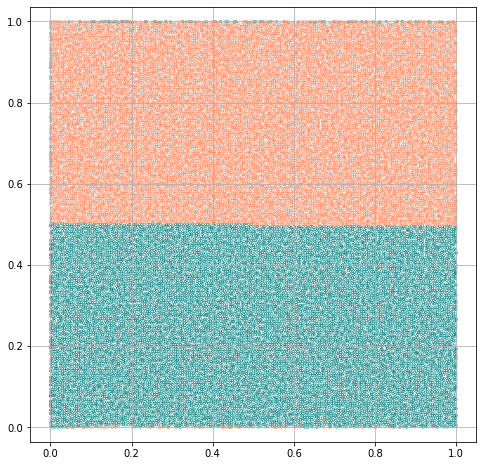

In [16]:
display(result[0], result[1])